<a href="https://colab.research.google.com/github/appravi18/PCA/blob/main/YieldCurve_Classical_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import datetime as dt
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})

In [37]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
from matplotlib.pyplot import figure
figure(figsize=(27, 12))

import seaborn as sns
sns.set_style('darkgrid')
sns.set_context("talk")

<Figure size 1944x864 with 0 Axes>

In [4]:
def get_data():
  all_data = []
  for i in range(10,23):
    year = str(2000+i)
    url1 = 'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv/'+year+'/all?type=daily_treasury_yield_curve&field_tdr_date_value='+year+'page&_format=csv'
    data = pd.read_csv(url1)
    all_data.append(data)

  pd_alldata = pd.concat(all_data,ignore_index=True)
  pd_alldata['Date'] = pd.to_datetime(pd_alldata['Date'])
  pd_alldata.index = pd_alldata['Date']
   
  req_cols = ['3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr','10 Yr', '20 Yr', '30 Yr']
  final = pd_alldata[req_cols]

  return final

In [5]:
final = get_data()

In [6]:
final.dropna(how='any',inplace=True)

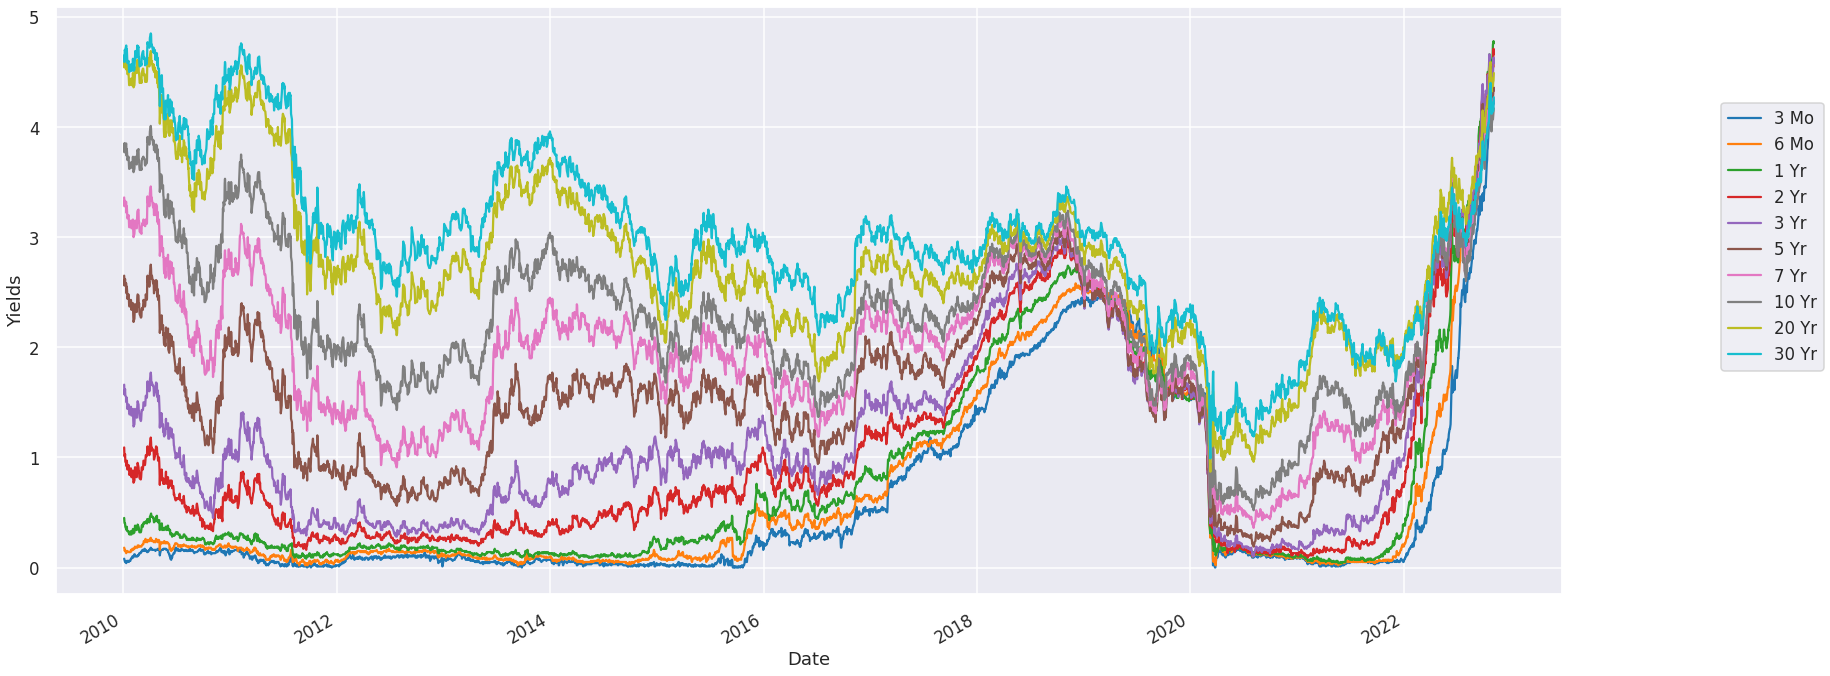

In [38]:
final.plot(figsize=(27,12))
plt.ylabel("Yields")
plt.legend(bbox_to_anchor=(1.1, 0.85), loc=2)
plt.show()

In [8]:
from scipy.optimize import minimize, rosen_der, fmin

In [9]:
def zero_coupon(tau, r0, kappa, theta, sigma, model):
  if model == 'Vasicek':
     B = (1- np.exp(-kappa * tau)) / kappa
     A = (theta - sigma**2 / (2* kappa**2)) *(B - tau) - (sigma**2 / (4 * kappa)) * B**2
     r = np.repeat(r0, len(A))
     p = np.exp(A - B * r)
     return p

In [10]:
def zero_coupon(tau, r0, kappa, theta, sigma, model):
  if model == 'Vasicek':
    B = (1- np.exp(-kappa * tau)) / kappa
    A = (theta - sigma**2 / (2* kappa**2)) * (B - tau) - (sigma**2 / (4 * kappa)) * B**2

  elif model == 'CIR':
    g = np.sqrt(kappa**2 + 2*sigma**2)
    tmp = 2 * kappa * theta / sigma**2
    tmp1 = kappa * tau /2
    tmp2 = g * tau /2

    A = tmp* np.log(np.exp(tmp1)/ (np.cosh(tmp2) + (kappa/ g) * np.sinh(tmp2))) 
    th = np.tanh(g * tau /2)
    B = 2. * th / (kappa * th + g)

  else:
    print('zero coupon: model must be Vasicek or CIR')
    return -1

  n2 = len(A)

  A_ = A
  B_ = B

  r_ = np.repeat(r0, n2)
  p = np.exp(A_ - B_ * r_)
  #print("A = ",A_, "B= ",B_, "r =",r_)
  return p

In [11]:
def swapRates(tau, p, mat):
  tmax = mat[-1]

  ttemp = np.arange(0.5, tmax + 0.5, 0.5)
  ptemp = np.interp(ttemp, tau, p)

  dis = np.cumsum(ptemp)
  pmat = np.interp(mat, tau, p)

  index = (2 * mat).astype(int) - 1
  S = 100 * 2 * (1- pmat)/dis[index]

  return S

In [12]:
def objFunc(params, tau, SWAP, model):
  r0 = params[0]
  kappa = params[1]
  theta = params[2]
  sigma = params[3]

  p = zero_coupon(tau, r0, kappa, theta, sigma, model)
  S = swapRates(tau, p, SWAP[:,0])

  rel1 = (S - SWAP[:,1])/SWAP[:,1]

  mse = np.sum(rel1**2)
  return mse

In [13]:
def objFuncMaturityAdjusted(params, tau, SWAP, model):
  r0 = params[0]
  kappa = params[1]
  theta = params[2]
  sigma = params[3]

  p = zero_coupon(tau, r0, kappa, theta, sigma, model)
  S = swapRates(tau, p, SWAP[:,0])

  rel1 = ((S - SWAP[:,1])/SWAP[:,1])*SWAP[:,0]

  mse = np.sum(rel1**2)
  return mse


In [71]:
def calibration(fun,params, tau, SWAP, model):
  sol = minimize(fun,params, args= (tau,SWAP,model),method='Nelder-Mead', bounds=[[-1,10],[1e-15,10],[1e-15,10], [1e-15,1]],
                 options={'maxiter':100000,'maxfev':5e3,'adaptive':True})
  

  #print(sol)
  par = np.array(sol.x)
  #print('parameters =' +str(par))

  r_star = par[0]
  kappa_star = par[1]
  theta_star = par[2]
  sigma_star = par[3]
  
  p = zero_coupon(tau,r_star,kappa_star,theta_star,sigma_star,model)
  S = swapRates(tau, p, SWAP[:,0])

  return p, S, par, sol

In [15]:
#we are going out 30 years every 6-months (1/2)
tau = np.arange(0, 30 + 1/2, 1/2)

#initial starting point
# r0 = 0.02, kappa0 = 2, theta0 = 0.5, sigma0 = 0.1
params = np.array([0.05, 0.02, 4.0, 0.25]);

In [16]:
model = 'Vasicek'

In [17]:
tenors_in_years = np.asarray([0.25,0.5,1.0,2.0,3.0,5.0,7.0,10.0,20.0,30.0])

In [66]:
final.iloc[-1]

3 Mo     0.08
6 Mo     0.22
1 Yr     0.40
2 Yr     0.78
3 Yr     1.04
5 Yr     1.37
7 Yr     1.55
10 Yr    1.63
20 Yr    2.05
30 Yr    2.01
Name: 2022-01-03 00:00:00, dtype: float64

In [60]:
tmp3 = final.iloc[-1].values.tolist()
SwapTest = np.asarray(list(zip(tenors_in_years,tmp3)))

In [61]:
p1, S1, params1,sol1 = calibration(objFunc,params,tau,SwapTest,model)
p2, S2, params2,sol2 = calibration(objFuncMaturityAdjusted,params,tau,SwapTest,model)

 final_simplex: (array([[ 0.00095,  0.03227,  0.18974,  0.02568],
       [ 0.00095,  0.03227,  0.18969,  0.02567],
       [ 0.00095,  0.03227,  0.18970,  0.02567],
       [ 0.00095,  0.03227,  0.18971,  0.02567],
       [ 0.00095,  0.03227,  0.18983,  0.02568]]), array([ 1.04894,  1.04894,  1.04894,  1.04894,  1.04894]))
           fun: 1.0489394922211743
       message: 'Optimization terminated successfully.'
          nfev: 386
           nit: 224
        status: 0
       success: True
             x: array([ 0.00095,  0.03227,  0.18974,  0.02568])
parameters =[ 0.00095  0.03227  0.18974  0.02568]
 final_simplex: (array([[ 0.00281,  0.05620,  0.09258,  0.02392],
       [ 0.00281,  0.05621,  0.09252,  0.02391],
       [ 0.00280,  0.05620,  0.09266,  0.02394],
       [ 0.00280,  0.05620,  0.09265,  0.02393],
       [ 0.00282,  0.05620,  0.09251,  0.02391]]), array([ 1.19326,  1.19328,  1.19329,  1.19331,  1.19331]))
           fun: 1.1932599014077085
       message: 'Optimization termi

In [62]:
SwapTest[:,1],S1,S2

(array([ 0.08000,  0.22000,  0.40000,  0.78000,  1.04000,  1.37000,
         1.55000,  1.63000,  2.05000,  2.01000]),
 array([ 0.00273,  0.24375,  0.38571,  0.64929,  0.88671,  1.28842,
         1.60235,  1.93453,  2.23589,  1.86267]),
 array([ 0.00445,  0.40379,  0.51975,  0.73220,  0.92050,  1.23312,
         1.47353,  1.72856,  2.04273,  2.00945]))

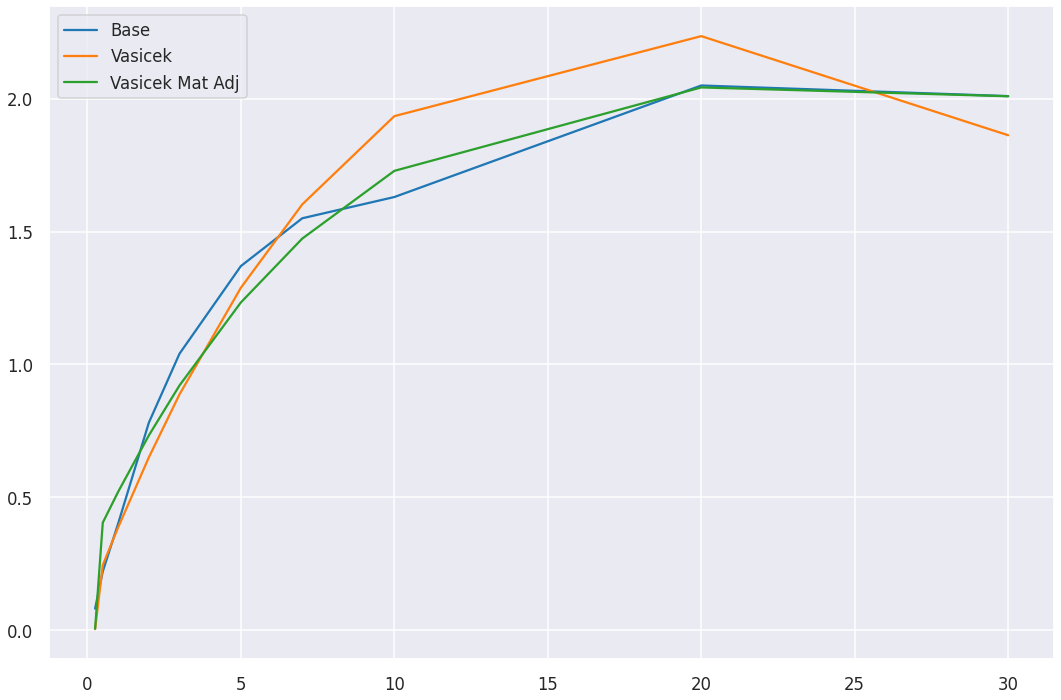

In [63]:
plt.plot(SwapTest[:,0],SwapTest[:,1],label='Base')
plt.plot(SwapTest[:,0],S1,label='Vasicek')
plt.plot(SwapTest[:,0],S2,label='Vasicek Mat Adj')
plt.legend()
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()

In [76]:
tmp3 = final.iloc[50].values.tolist()
SwapTest = np.asarray(list(zip(tenors_in_years,tmp3)))

model = 'Vasicek'

p1, S1, params1,sol1 = calibration(objFunc,params,tau,SwapTest,model)
p2, S2, params2,sol2 = calibration(objFuncMaturityAdjusted,params,tau,SwapTest,model)

model = 'CIR'
p3, S3, params3,sol3 = calibration(objFunc,params,tau,SwapTest,model)
p4, S4, params4,sol4 = calibration(objFuncMaturityAdjusted,params,tau,SwapTest,model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


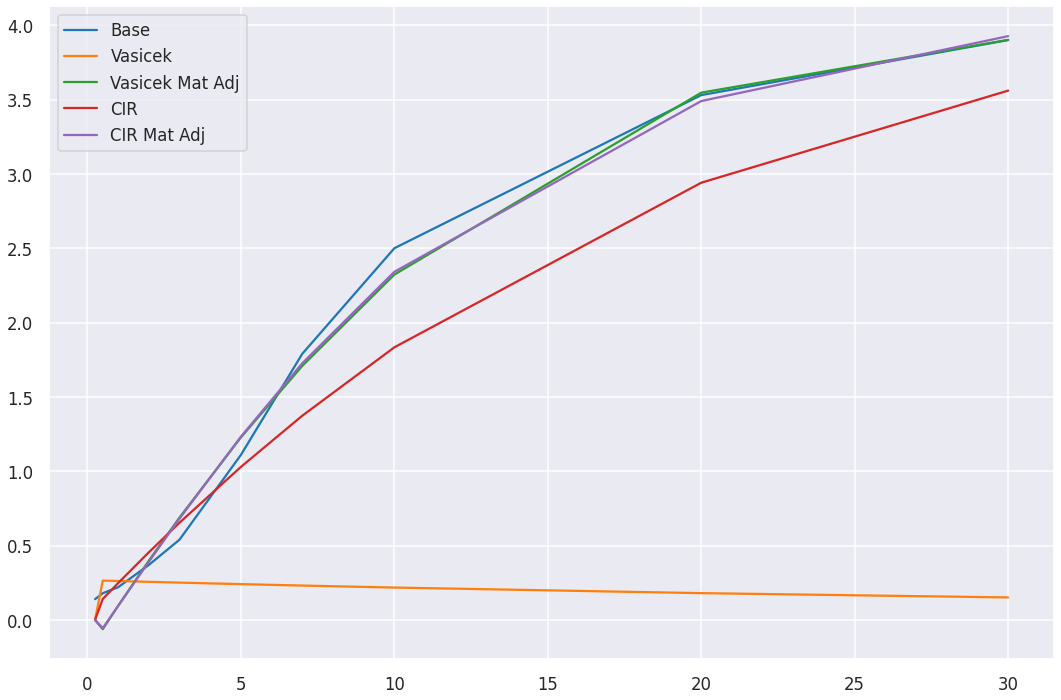

In [77]:
plt.plot(SwapTest[:,0],SwapTest[:,1],label='Base')
plt.plot(SwapTest[:,0],S1,label='Vasicek')
plt.plot(SwapTest[:,0],S2,label='Vasicek Mat Adj')

plt.plot(SwapTest[:,0],S3,label='CIR')
plt.plot(SwapTest[:,0],S4,label='CIR Mat Adj')

plt.legend()
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()

In [78]:
!pip install nelson-siegel-svensson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [88]:
curve0, status0 = calibrate_nss_ols(tenors_in_years, np.array(tmp3), tau0=[0.0609,0.0295])  # starting value of 1.0 for the optimization of tau
assert status0.success
print(curve0)

NelsonSiegelSvenssonCurve(beta0=4.620155433774143, beta1=-4.569844148932379, beta2=-6462.106297842444, beta3=6455.250037728308, tau1=1.4531792658280782, tau2=1.4523974266438613)


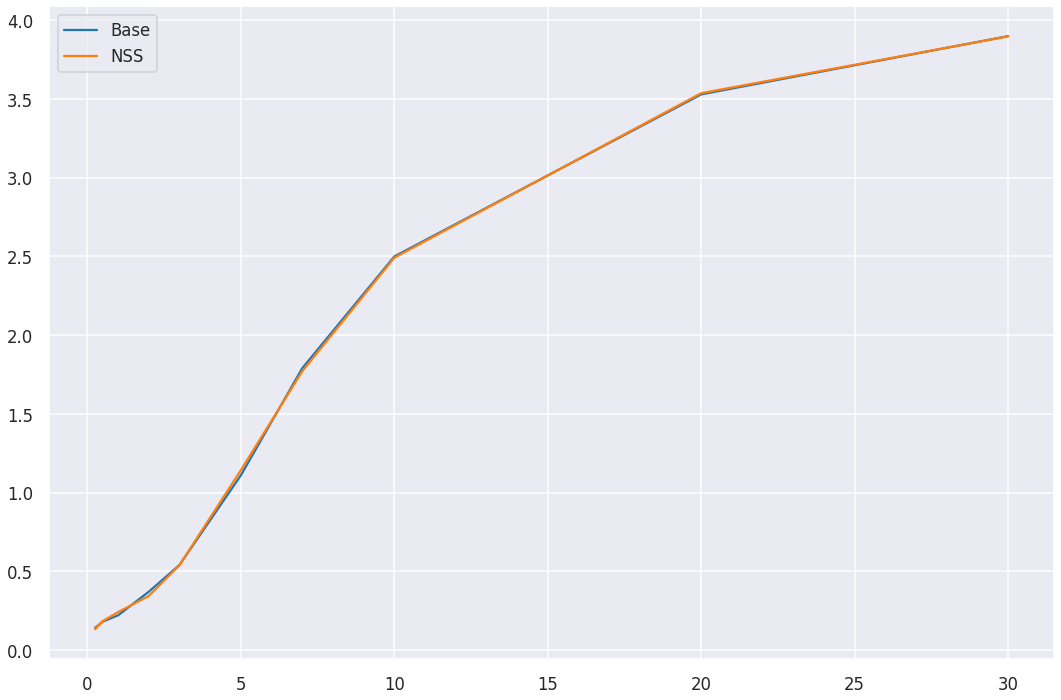

In [89]:
plt.plot(tenors_in_years, np.array(tmp3),label='Base')
plt.plot(tenors_in_years, curve0(tenors_in_years),label='NSS')
plt.legend()
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()

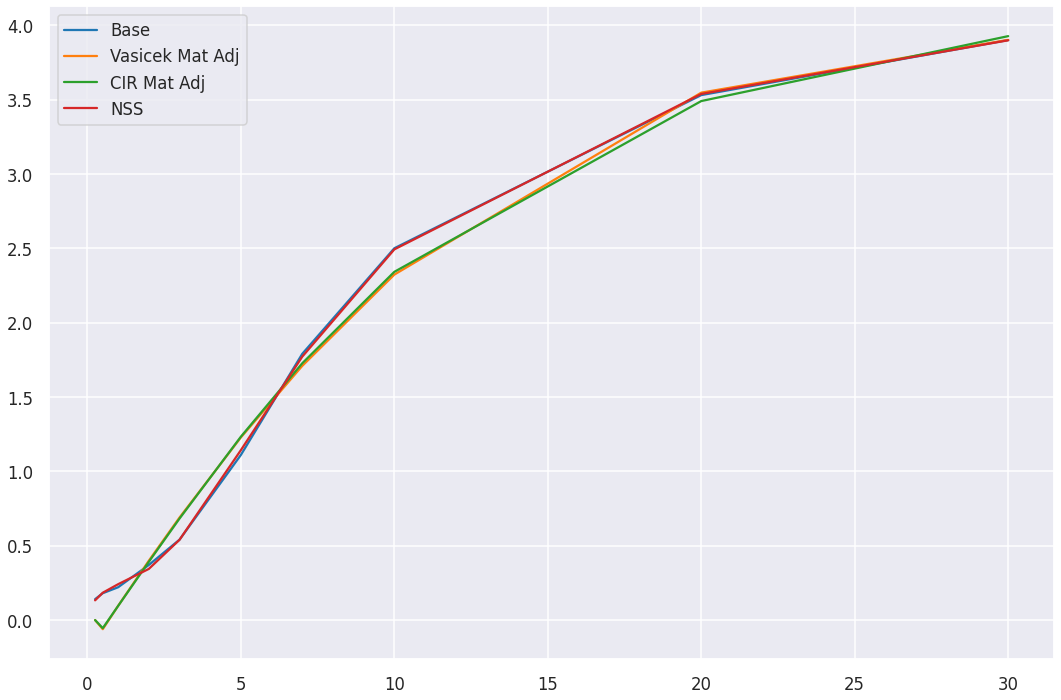

In [90]:
plt.plot(SwapTest[:,0],SwapTest[:,1],label='Base')
plt.plot(SwapTest[:,0],S2,label='Vasicek Mat Adj')
plt.plot(SwapTest[:,0],S4,label='CIR Mat Adj')
plt.plot(tenors_in_years, curve0(tenors_in_years),label='NSS')
plt.legend()
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()